# Supplementary data: recombination events

## Setup

In [1]:
%run ../../shared_setup.ipynb

In [2]:
# load variation data
sample_exclusions = dup_samples.copy()
for cross in excessive_recomb_samples:
    sample_exclusions[cross] += excessive_recomb_samples[cross]

callsets = load_callsets(COMBINED_CALLSET_FN_TEMPLATE, 
                         sample_exclusions=sample_exclusions, 
                         variant_filter='FILTER_PASS',
                         call_filter=combined_conf_calls)

samples = {cross: callsets[cross]['calldata'].dtype.names
           for cross in CROSSES}
progeny = {cross: samples[cross][2:] for cross in CROSSES}
n_progeny = {cross: len(progeny[cross]) for cross in CROSSES}
print(n_progeny)
print(np.sum(n_progeny.values()))

2015-04-02 16:22:20.907815 :: loading /data/plasmodium/pfalciparum/pf-crosses/data/public/20141022/3d7_hb3.combined.final.npz
2015-04-02 16:22:21.108725 :: filter variants: excluding 157 (0.4%) retaining 42087 (99.6%) of 42244 variants
2015-04-02 16:22:21.125160 :: filter samples: excluding ['C01/PG0062-C/ERR019070', 'C02/PG0053-C/ERR019067', 'C02/PG0055-C/ERR019066', 'C02/PG0056-C/ERR019068'] including ['3D7/PG0051-C/ERR019061', 'HB3/PG0052-C/ERR019054', 'C01/PG0065-C/ERR019064', 'C02/PG0067-C/ERR019073', 'C03/PG0066-C/ERR019072', 'C04/PG0061-C/ERR019059', 'C05/PG0068-C/ERR019065', 'C06/PG0069-C/ERR019055', 'C07/PG0070-C/ERR019056', 'C08/PG0071-C/ERR019074', 'C09/PG0072-C/ERR019057', 'C10/PG0063-C/ERR019060', 'C11/PG0064-C/ERR019071', 'C12/PG0058-C/ERR019063', 'C13/PG0054-C/ERR019062', 'C14/PG0060-C/ERR019058', 'C15/PG0057-C/ERR019069']
2015-04-02 16:22:21.183573 :: filter calls: excluding 95743 (13.4%) retaining 619736 (86.6%) of 715479 calls
2015-04-02 16:22:21.184663 :: loading /da

{'7g8_gb4': 27, 'hb3_dd2': 34, '3d7_hb3': 15}
dict_values([27, 34, 15])


## CO recombination events

To infer CO events we first mask out genotypes on blocks shorter than 10kb.

In [3]:
min_co_block_size = 10000
callsets_co = {cross: filter_calls(callsets[cross], min_haplen_calls(min_co_block_size))
               for cross in CROSSES}

2015-04-02 16:22:23.905119 :: filter calls: excluding 719 (0.1%) retaining 714760 (99.9%) of 715479 calls
2015-04-02 16:22:24.061600 :: filter calls: excluding 1756 (0.1%) retaining 1310840 (99.9%) of 1312596 calls
2015-04-02 16:22:24.188105 :: filter calls: excluding 1339 (0.1%) retaining 998320 (99.9%) of 999659 calls


In [4]:
def tabulate_crossovers(cross):
    variants, calldata, _ = unpack_callset(callsets_co[cross])
    tbl = (
        tabulate_switches(variants, calldata)
        .addfield('cross', cross)
        .rename({'pos': 'co_pos_mid', 'lpos': 'co_pos_min', 'rpos': 'co_pos_max', 'range': 'co_pos_range'})
        .addfield('co_from_parent', lambda r: r.cross.split('_')[r['from'] - 7])
        .addfield('co_to_parent', lambda r: r.cross.split('_')[r['to'] - 7])
        .cutout('from', 'to')
    )
    return etl.wrap(tbl)  


tbl_co = (etl
    .cat(*[tabulate_crossovers(cross) for cross in CROSSES])
    .sort(key=('chrom', 'co_pos_mid'))
)
tbl_co.totsv(os.path.join(PUBLIC_DIR, 'tbl_co.txt'))
tbl_co.topickle(os.path.join(PUBLIC_DIR, 'tbl_co.pickle'))
display_with_nrows(tbl_co, caption='CO events')

0|sample,1|chrom,2|co_pos_mid,3|co_pos_min,4|co_pos_max,5|co_pos_range,6|cross,7|co_from_parent,8|co_to_parent
B1SD/PG0015-C/ERR019044,b'Pf3D7_01_v3',145052.0,144877,145227,350,hb3_dd2,hb3,dd2
GC03/PG0021-C/ERR015447,b'Pf3D7_01_v3',163584.5,163145,164024,879,hb3_dd2,dd2,hb3
XF12/PG0102-C/ERR029143,b'Pf3D7_01_v3',206769.5,205803,207736,1933,7g8_gb4,gb4,7g8
7C159/PG0040-Cx/ERR107475,b'Pf3D7_01_v3',206905.0,206074,207736,1662,hb3_dd2,hb3,dd2
CH3_61/PG0033-Cx/ERR175544,b'Pf3D7_01_v3',206905.0,206074,207736,1662,hb3_dd2,dd2,hb3


## Conversion tracts

### Identify short blocks

Start by tabulating all the short inheritance blocks individually.

In [5]:
def tabulate_short_inheritance_blocks(cross):
    variants, calldata, _ = unpack_callset(callsets[cross])
    _, _, tbl_blocks = haplotypes(variants, calldata)   
    tbl = (
        tbl_blocks
        .select(lambda r: r.length_min < min_co_block_size and r.nxt_inheritance != -1 and r.prv_inheritance != -1)
        .addfield('cross', cross)
        .addfield('is_complex', False)
        .addfield('blocks', 1)
    )
    return tbl


tbl_short_blocks = (etl
    .cat(*[tabulate_short_inheritance_blocks(cross) for cross in CROSSES])
    .sort(key=('sample', 'chrom', 'start_min'))
)
display_with_nrows(tbl_short_blocks, caption='short inheritance blocks')

0|sample,1|chrom,2|start_min,3|start_mid,4|start_max,5|stop_min,6|stop_mid,7|stop_max,8|length_min,9|length_mid,10|length_max,11|support,12|prv_inheritance,13|inheritance,14|nxt_inheritance,15|cross,16|is_complex,17|blocks
1BB5/PG0023-C/ERR015449,b'Pf3D7_02_v3',551191,551710,552230,553726,555172,556618,1496,3462,5427,3,8,7,8,hb3_dd2,False,1
1BB5/PG0023-C/ERR015449,b'Pf3D7_03_v3',810043,810060,810077,810077,811042,812008,0,982,1965,1,8,7,8,hb3_dd2,False,1
1BB5/PG0023-C/ERR015449,b'Pf3D7_05_v3',973050,973180,973311,973311,974623,975935,0,1443,2885,1,7,8,7,hb3_dd2,False,1
1BB5/PG0023-C/ERR015449,b'Pf3D7_08_v3',1293542,1294381,1295221,1296788,1297035,1297283,1567,2654,3741,3,7,8,7,hb3_dd2,False,1
1BB5/PG0023-C/ERR015449,b'Pf3D7_08_v3',1314649,1314740,1314831,1314831,1315166,1315502,0,426,853,1,7,8,7,hb3_dd2,False,1


In [6]:
tbl_short_blocks.valuecounts('sample').head(10)

0|sample,1|count,2|frequency
CH3_61/PG0033-Cx/ERR175544,38,0.038461538461538464
JF6/PG0079-C/ERR027102,33,0.03340080971659919
B1SD/PG0015-C/ERR019044,32,0.032388663967611336
JC3/PG0077-CW/ERR045636,26,0.02631578947368421
NIC/PG0095-CW/ERR045631,26,0.02631578947368421


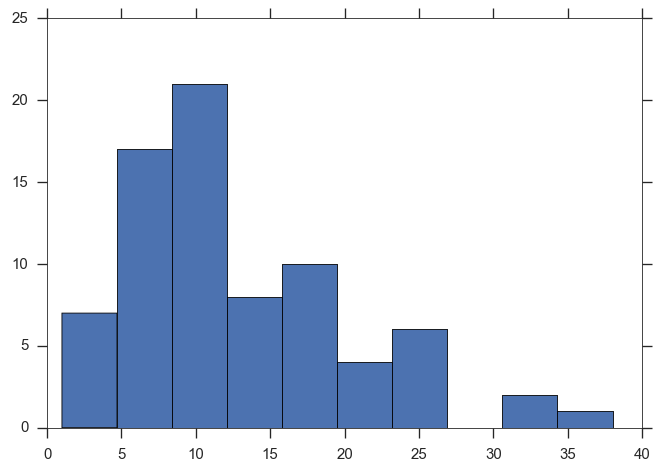

In [7]:
df_sb = tbl_short_blocks.valuecounts('sample').todataframe()
plt.hist(df_sb['count']);

### Combine adjacent blocks into conversion tracts 

Now combine adjacent blocks together.

In [14]:
class MergeAdjacentBlocks(object):
    
    def __init__(self, source):
        self.source = source
        
    def __iter__(self):
        it = iter(self.source)
        fields = next(it)
        it = etl.util.iterrecords(fields, it)
        yield ['sample', 'cross', 'chrom', 'start_min', 'start_mid', 'start_max', 'stop_min', 'stop_mid', 'stop_max', 'length_min', 'length_mid', 'length_max', 'support', 'is_complex', 'blocks']
        cur = next(it)
        sample = cur.sample
        cross = cur.cross
        chrom = cur.chrom
        start_min = cur.start_min
        start_mid = cur.start_mid
        start_max = cur.start_max
        stop_min = cur.stop_min
        stop_mid = cur.stop_mid
        stop_max = cur.stop_max
        length_min = cur.length_min
        length_mid = cur.length_mid
        length_max = cur.length_max
        support = cur.support
        is_complex = cur.is_complex
        blocks = cur.blocks
        for cur in it:
            # are they adjacent?
            if sample == cur.sample and chrom == cur.chrom and stop_mid == cur.start_mid:
                # yes, merge
                stop_min = cur.stop_min
                stop_mid = cur.stop_mid
                stop_max = cur.stop_max
                support += cur.support
                length_min = stop_min - start_max
                length_max = stop_max - start_min
                length_mid = stop_mid - start_mid
                is_complex = True
                blocks += 1
            else:
                # yield previous
                yield (sample, cross, chrom, start_min, start_mid, start_max, stop_min, stop_mid, stop_max, length_min, length_mid, length_max, support, is_complex, blocks)
                # reset
                sample = cur.sample
                cross = cur.cross
                chrom = cur.chrom
                start_min = cur.start_min
                start_mid = cur.start_mid
                start_max = cur.start_max
                stop_min = cur.stop_min
                stop_mid = cur.stop_mid
                stop_max = cur.stop_max
                length_min = cur.length_min
                length_mid = cur.length_mid
                length_max = cur.length_max
                support = cur.support
                is_complex = cur.is_complex
                blocks = cur.blocks
        # handle last one left over
        yield (sample, cross, chrom, start_min, start_mid, start_max, stop_min, stop_mid, stop_max, length_min, length_mid, length_max, support, is_complex, blocks)


In [15]:
tbl_conversion_tracts = etl.wrap(
    MergeAdjacentBlocks(tbl_short_blocks.cutout('prv_inheritance', 'inheritance', 'nxt_inheritance'))
)
display_with_nrows(tbl_conversion_tracts, caption='conversion tracts')

AttributeError: 'module' object has no attribute 'iterrecords'

In [10]:
tbl_conversion_tracts.valuecounts('sample').head()

0|sample,1|count,2|frequency
CH3_116/PG0032-Cx/ERR037703,44,0.0477741585233
CH3_61/PG0033-Cx/ERR175544,38,0.0412595005429
JB12/PG0099-C/ERR029146,32,0.0347448425624
B1SD/PG0015-C/ERR019044,30,0.0325732899023
7C183/PG0042-C/ERR015448,26,0.028230184582


In [11]:
tbl_conversion_tracts.valuecounts('is_complex')

0|is_complex,1|count,2|frequency
False,773,0.839305103149
True,148,0.160694896851


In [12]:
tbl_conversion_tracts.valuecounts('blocks')

0|blocks,1|count,2|frequency
1,773,0.839305103149
2,86,0.0933767643865
3,42,0.0456026058632
4,10,0.0108577633008
5,3,0.00325732899023


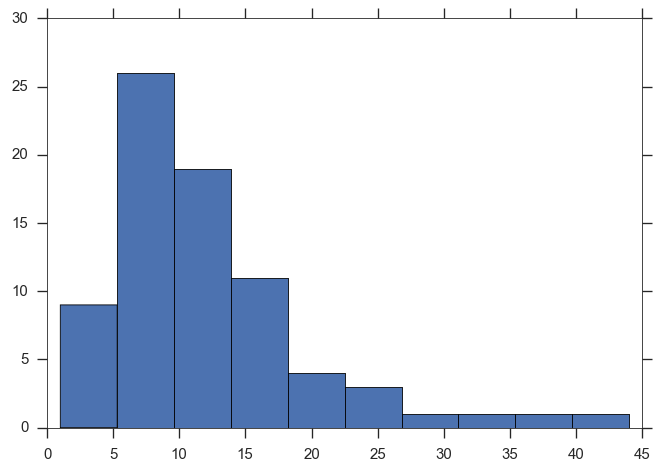

In [13]:
X = tbl_conversion_tracts.valuecounts('sample').values('count').list()
plt.hist(X);

### Identify tracts with robust support

In [14]:
tbl_tracts_robust = tbl_conversion_tracts.select(lambda r: r.support > 1 and r.length_min > 100)
display_with_nrows(tbl_tracts_robust, caption='conversion tracts with robust support')

0|sample,1|cross,2|chrom,3|start_min,4|start_mid,5|start_max,6|stop_min,7|stop_mid,8|stop_max,9|length_min,10|length_mid,11|length_max,12|support,13|is_complex,14|blocks
1BB5/PG0023-C/ERR015449,hb3_dd2,Pf3D7_02_v3,551191,551710,552230,553769,554132,554496,1539,2422,3305,5,False,1
1BB5/PG0023-C/ERR015449,hb3_dd2,Pf3D7_08_v3,1293542,1294381,1295221,1296788,1297035,1297283,1567,2654,3741,4,False,1
1BB5/PG0023-C/ERR015449,hb3_dd2,Pf3D7_08_v3,1337134,1337350,1337567,1346702,1347132,1347563,9135,9782,10429,24,True,8
1BB5/PG0023-C/ERR015449,hb3_dd2,Pf3D7_09_v3,950476,951138,951801,954256,954735,955215,2455,3597,4739,4,True,3
1BB5/PG0023-C/ERR015449,hb3_dd2,Pf3D7_12_v3,331487,331820,332154,336886,337497,338108,4732,5677,6621,7,False,1


In [15]:
tbl_tracts_robust.valuecounts('is_complex')

0|is_complex,1|count,2|frequency
False,190,0.574018126888
True,141,0.425981873112


In [16]:
tbl_tracts_robust.valuecounts('blocks')

0|blocks,1|count,2|frequency
1,190,0.574018126888
2,82,0.247734138973
3,39,0.117824773414
4,10,0.0302114803625
5,3,0.00906344410876


In [17]:
tbl_tracts_robust.valuecounts('sample').head(5).display()
tbl_tracts_robust.valuecounts('sample').tail(5).display()

0|sample,1|count,2|frequency
7C111/PG0038-C/ERR015457,10,0.0302114803625
JF6/PG0079-C/ERR027102,10,0.0302114803625
CH3_61/PG0033-Cx/ERR175544,9,0.0271903323263
C09/PG0072-C/ERR019057,8,0.02416918429
7C183/PG0042-C/ERR015448,8,0.02416918429


0|sample,1|count,2|frequency
TC05/PG0027-C/ERR015450,2,0.00604229607251
QC34/PG0026-C/ERR015453,1,0.00302114803625
7C408/PG0031-C/ERR015458,1,0.00302114803625
7C126/PG0047-C/ERR015452,1,0.00302114803625
XF12/PG0102-C/ERR029143,1,0.00302114803625


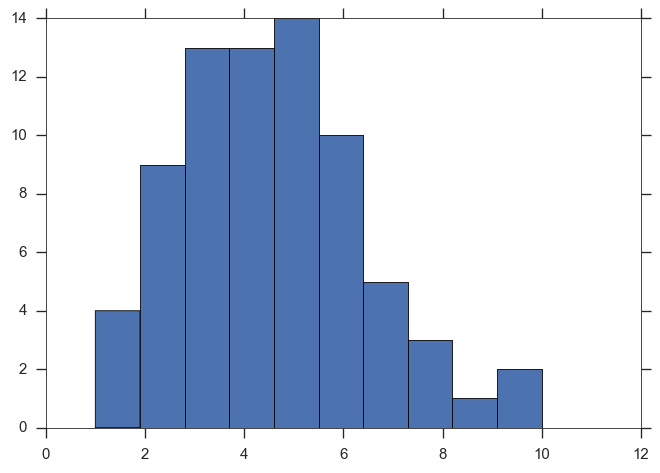

In [18]:
X = tbl_tracts_robust.valuecounts('sample').values('count').list()
plt.hist(X, bins=10);

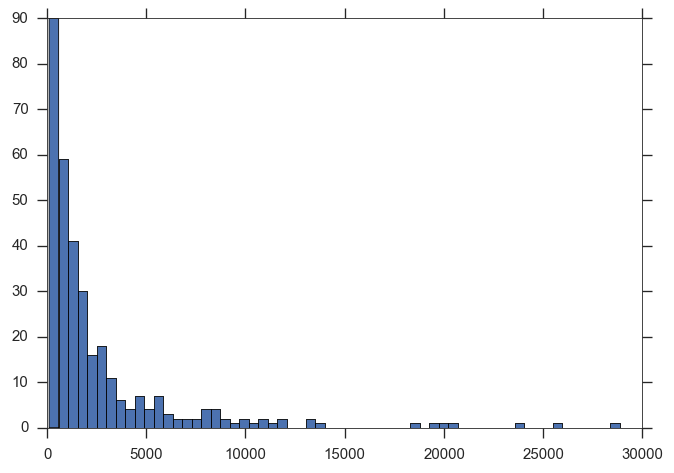

In [19]:
X = tbl_tracts_robust.values('length_min').list()
plt.hist(X, bins=60);

## Differentiate CO and NCO conversion tracts

Now figure out which conversion tracts are associated with COs and which are NCOs...

In [20]:
tbl_tracts_differentiated = (
    tbl_tracts_robust
    .addfield('facet', lambda r: '%s_%s' % (r.sample, r.chrom))
    .intervalleftjoin(tbl_co.addfield('facet', lambda r: '%s_%s' % (r.sample, r.chrom)), 
                      lfacet='facet', 
                      rfacet='facet', 
                      lstart='start_min', 
                      lstop='stop_max', 
                      rstart='co_pos_min', 
                      rstop='co_pos_max')
    .cutout(15, 16, 17, 22, 23, 24, 25)
    .rename({
        'start_min': 'tract_start_min',
        'start_mid': 'tract_start_mid',
        'start_max': 'tract_start_max',
        'stop_min': 'tract_stop_min',
        'stop_mid': 'tract_stop_mid',
        'stop_max': 'tract_stop_max',
        'length_min': 'tract_length_min',
        'length_mid': 'tract_length_mid',
        'length_max': 'tract_length_max',
        'support': 'tract_support',
        'is_complex': 'tract_is_complex',
        'blocks': 'tract_blocks',
    })
    .addfield('tract_type', lambda row: 'NCO' if row.co_pos_min is None else 'CO')
)
tbl_tracts_differentiated.topickle(os.path.join(PUBLIC_DIR, 'tbl_conversion_tracts.pickle'))
tbl_tracts_differentiated.totsv(os.path.join(PUBLIC_DIR, 'tbl_conversion_tracts.txt'))
display_with_nrows(tbl_tracts_differentiated, caption='differentiated conversion tracts')

0|sample,1|cross,2|chrom,3|tract_start_min,4|tract_start_mid,5|tract_start_max,6|tract_stop_min,7|tract_stop_mid,8|tract_stop_max,9|tract_length_min,10|tract_length_mid,11|tract_length_max,12|tract_support,13|tract_is_complex,14|tract_blocks,15|co_pos_mid,16|co_pos_min,17|co_pos_max,18|co_pos_range,19|tract_type
1BB5/PG0023-C/ERR015449,hb3_dd2,Pf3D7_02_v3,551191,551710,552230,553769,554132,554496,1539,2422,3305,5,False,1,None,None,None,None,NCO
1BB5/PG0023-C/ERR015449,hb3_dd2,Pf3D7_08_v3,1293542,1294381,1295221,1296788,1297035,1297283,1567,2654,3741,4,False,1,None,None,None,None,NCO
1BB5/PG0023-C/ERR015449,hb3_dd2,Pf3D7_08_v3,1337134,1337350,1337567,1346702,1347132,1347563,9135,9782,10429,24,True,8,1342348,1337134,1347563,10429,CO
1BB5/PG0023-C/ERR015449,hb3_dd2,Pf3D7_09_v3,950476,951138,951801,954256,954735,955215,2455,3597,4739,4,True,3,None,None,None,None,NCO
1BB5/PG0023-C/ERR015449,hb3_dd2,Pf3D7_12_v3,331487,331820,332154,336886,337497,338108,4732,5677,6621,7,False,1,None,None,None,None,NCO


In [21]:
tbl_tracts_differentiated.valuecounts('tract_type')

0|tract_type,1|count,2|frequency
NCO,235,0.70996978852
CO,96,0.29003021148


In [22]:
tbl_tracts_co = tbl_tracts_differentiated.eq('tract_type', 'CO')
display_with_nrows(tbl_tracts_co, caption='CO conversion tracts')

0|sample,1|cross,2|chrom,3|tract_start_min,4|tract_start_mid,5|tract_start_max,6|tract_stop_min,7|tract_stop_mid,8|tract_stop_max,9|tract_length_min,10|tract_length_mid,11|tract_length_max,12|tract_support,13|tract_is_complex,14|tract_blocks,15|co_pos_mid,16|co_pos_min,17|co_pos_max,18|co_pos_range,19|tract_type
1BB5/PG0023-C/ERR015449,hb3_dd2,Pf3D7_08_v3,1337134,1337350,1337567,1346702,1347132,1347563,9135,9782,10429,24,True,8,1342348,1337134,1347563,10429,CO
3BD5/PG0024-C/ERR019053,hb3_dd2,Pf3D7_03_v3,912649,912727,912805,916518,916794,917070,3713,4067,4421,8,True,2,914859,912649,917070,4421,CO
3BD5/PG0024-C/ERR019053,hb3_dd2,Pf3D7_04_v3,729031,729218,729405,733911,734356,734801,4506,5138,5770,7,True,2,731916,729031,734801,5770,CO
3BD5/PG0024-C/ERR019053,hb3_dd2,Pf3D7_10_v3,225428,226716,228004,229437,229802,230167,1433,3086,4739,3,True,2,227797,225428,230167,4739,CO
3BD5/PG0024-C/ERR019053,hb3_dd2,Pf3D7_10_v3,1341344,1342132,1342921,1361560,1361995,1362430,18639,19863,21086,32,True,6,1351887,1341344,1362430,21086,CO


In [23]:
tbl_tracts_nco = tbl_tracts_differentiated.eq('tract_type', 'NCO').cutout(15, 16, 17, 18, 19)
display_with_nrows(tbl_tracts_nco, caption='NCO conversion tracts')

0|sample,1|cross,2|chrom,3|tract_start_min,4|tract_start_mid,5|tract_start_max,6|tract_stop_min,7|tract_stop_mid,8|tract_stop_max,9|tract_length_min,10|tract_length_mid,11|tract_length_max,12|tract_support,13|tract_is_complex,14|tract_blocks
1BB5/PG0023-C/ERR015449,hb3_dd2,Pf3D7_02_v3,551191,551710,552230,553769,554132,554496,1539,2422,3305,5,False,1
1BB5/PG0023-C/ERR015449,hb3_dd2,Pf3D7_08_v3,1293542,1294381,1295221,1296788,1297035,1297283,1567,2654,3741,4,False,1
1BB5/PG0023-C/ERR015449,hb3_dd2,Pf3D7_09_v3,950476,951138,951801,954256,954735,955215,2455,3597,4739,4,True,3
1BB5/PG0023-C/ERR015449,hb3_dd2,Pf3D7_12_v3,331487,331820,332154,336886,337497,338108,4732,5677,6621,7,False,1
1BB5/PG0023-C/ERR015449,hb3_dd2,Pf3D7_13_v3,756601,756957,757313,760183,761269,762355,2870,4312,5754,9,False,1


In [24]:
tbl_tracts_nco.valuecounts('tract_is_complex')

0|tract_is_complex,1|count,2|frequency
False,190,0.808510638298
True,45,0.191489361702


In [25]:
tbl_tracts_differentiated.gt('tract_length_min', 15000).displayall()

0|sample,1|cross,2|chrom,3|tract_start_min,4|tract_start_mid,5|tract_start_max,6|tract_stop_min,7|tract_stop_mid,8|tract_stop_max,9|tract_length_min,10|tract_length_mid,11|tract_length_max,12|tract_support,13|tract_is_complex,14|tract_blocks,15|co_pos_mid,16|co_pos_min,17|co_pos_max,18|co_pos_range,19|tract_type
3BD5/PG0024-C/ERR019053,hb3_dd2,Pf3D7_10_v3,1308754,1309392,1310031,1330511,1330807,1331104,20480,21415,22350,39,True,3,None,None,None,None,NCO
3BD5/PG0024-C/ERR019053,hb3_dd2,Pf3D7_10_v3,1341344,1342132,1342921,1361560,1361995,1362430,18639,19863,21086,32,True,6,1351887,1341344,1362430,21086,CO
7C3/PG0034-C/ERR019047,hb3_dd2,Pf3D7_08_v3,1202631,1203122,1203613,1227264,1227421,1227578,23651,24299,24947,44,True,5,None,None,None,None,NCO
C04/PG0061-C/ERR019059,3d7_hb3,Pf3D7_14_v3,2891817,2892879,2893941,2922794,2923016,2923239,28853,30137,31422,77,True,9,None,None,None,None,NCO
JC3/PG0077-CW/ERR045636,7g8_gb4,Pf3D7_08_v3,1207822,1208720,1209619,1228966,1229286,1229606,19347,20566,21784,42,True,10,1218714,1207822,1229606,21784,CO
JF6/PG0079-C/ERR027102,7g8_gb4,Pf3D7_11_v3,1685640,1686586,1687533,1713449,1713727,1714005,25916,27141,28365,40,True,7,None,None,None,None,NCO
JF6/PG0079-C/ERR027102,7g8_gb4,Pf3D7_11_v3,1726074,1726125,1726177,1746099,1747010,1747922,19922,20885,21848,42,True,11,None,None,None,None,NCO
